**Aarti Yadav**

**PRN No: 24070149029**

**Assignment No. 2  Construct an Autoencoder framework for detecting anomalies in an industrial pipeline. Choose any time-series data from the UCI repository.**

In [4]:
!pip install openpyxl
import pandas as pd

# Load the dataset using pd.read_excel()
data = pd.read_excel('/content/AirQualityUCI.xlsx')
data = data.dropna()  # Remove missing values

In [19]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


**Variable Information:**

0) Date	(DD/MM/YYYY)

1) Time	(HH.MM.SS)

2) True hourly averaged concentration CO in mg/m^3  (reference analyzer)

3) PT08.S1 (tin oxide)  hourly averaged sensor response (nominally  CO targeted)

4) True hourly averaged overall Non Metanic HydroCarbons concentration in microg/
m^3 (reference analyzer)

5) True hourly averaged Benzene concentration  in microg/m^3 (reference analyzer)

6) PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)

7) True hourly averaged NOx concentration  in ppb (reference analyzer)

8) PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)

9) True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)

10) PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)

11) PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)

12) Temperature in Â°C

13) Relative Humidity (%)

14) AH Absolute Humidity

**Dataset :** Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer.

**Dataset links: https://archive.ics.uci.edu/dataset/360/air+quality**

Preprocess the Data: Normalize the data to have zero mean and unit variance

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'NOx(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']])

Create Sequences: Generate sequences of data for training the Autoencoder.


In [6]:
import numpy as np

def create_sequences(data, time_steps=288):
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
    return np.array(sequences)

TIME_STEPS = 288
x_train = create_sequences(data_scaled)

Model Construction: Autoencoder Model Build.

In [7]:
from keras import layers, models

model = models.Sequential([
    layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
    layers.Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=2, padding='same'),
    layers.Conv1D(filters=16, kernel_size=7, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=2, padding='same'),
    layers.Conv1DTranspose(filters=16, kernel_size=7, padding='same', activation='relu'),
    layers.UpSampling1D(size=2),
    layers.Conv1DTranspose(filters=32, kernel_size=7, padding='same', activation='relu'),
    layers.UpSampling1D(size=2),
    layers.Conv1DTranspose(filters=1, kernel_size=7, padding='same')
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 288, 32)             │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 144, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 144, 16)             │           3,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 72, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose (Conv1DTranspose)   │ (None, 72, 16)              │           1,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d (UpSampling1D)         │ (None, 144, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_1 (Conv1DTranspose) │ (None, 144, 32)             │           3,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_1 (UpSampling1D)       │ (None, 288, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_2 (Conv1DTranspose) │ (None, 288, 1)              │             225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,969 (46.75 KB)

 Trainable params: 11,969 (46.75 KB)

 Non-trainable params: 0 (0.00 B)

**Training the parameter**

**Train the Autoencoder:** Fit the model using the training data.

In [14]:
from keras import layers, models
import keras
history = model.fit(x_train, x_train, epochs=50, batch_size=128, validation_split=0.1, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')])

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.7032 - val_loss: 0.3193
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - loss: 0.6239 - val_loss: 0.3159
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.6176 - val_loss: 0.3140
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.6119 - val_loss: 0.3127
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - loss: 0.6128 - val_loss: 0.3117
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.6158 - val_loss: 0.3108
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - loss: 0.6071 - val_loss: 0.3101
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.6139 - val_loss: 0.3094
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - loss: 0.6074 - val_loss: 0.3088
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.6059 - val_loss: 0.3083
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 0.6096 - val_loss: 0.3077
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/ste

**Anomaly Detection**

**Reconstruction and Error Calculation:** Using the trained model to reconstruct the input data and calculate the reconstruction error.

In [15]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


**Set Threshold for Anomalies:** Determine a threshold for identifying anomalies.

In [16]:
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  2.4843615412688655


**Detect Anomalies:** Identify samples that exceed the threshold.

In [17]:
anomalies = train_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))

Number of anomaly samples:  0


Visualization

Plot Results: Visualize the original data and the detected anomalies.


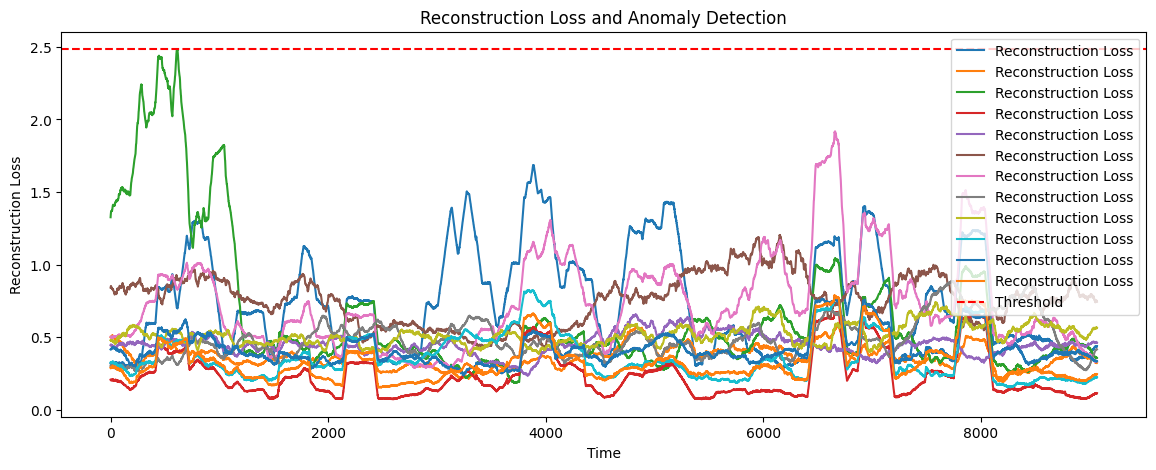

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(data.index[:len(train_mae_loss)], train_mae_loss, label='Reconstruction Loss')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Loss and Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.show()

**Results:**
#1. Reconstruction Loss:
* The y-axis represents the reconstruction loss, which measures the difference between the input and the reconstructed output from the autoencoder.

* Each colored line appears to represent the reconstruction loss for individual sequences, features, or timesteps.


#2. Time:
* The x-axis represents time (index or sequence number).


#3. Threshold:
* The red dashed line represents the threshold value. Points above this line are likely being classified as anomalies because their reconstruction loss
exceeds the acceptable threshold.


#4. Anomaly Detection:
* Peaks above the threshold are potential anomalies. These represent data points or time periods where the autoencoder failed to reconstruct the input effectively, suggesting unusual or anomalous behavior.